In notebooks 01-06, we looked at forecasts and actuals for 2024-09-12 thorugh 2024-04-12 for several examples. We intentionally left that date range our of our regression training sets, and not let's revisit them with our probabilistic tool.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from quantile_forest import RandomForestQuantileRegressor
import joblib

Read in data and load models:

In [2]:
df = pd.read_pickle('data_files/full_2021_2023_dataset.pkl')
booster = xgb.Booster()
booster.load_model("regression_models/xgboost_model.json")
qrf = joblib.load('regression_models/qrf_file.joblib')

Setup data:

In [3]:
filtered_df = df.dropna()
approx_nameplate = df.p_ac_all_cs.max() # use max of clear sky power as proxy for nameplate rating
filtered_df = filtered_df[filtered_df['p_ac_all_cs'] >= approx_nameplate*.001]
pi_list_xgb = [.9995, .999, .99, .96, .57] 
pi_list_rf = [.995, .99, .98, .95, .5]

X=filtered_df[['tcc_std']].copy()
X['max_min_norm'] = filtered_df['max_min_norm']
X['csi_fcast'] = filtered_df['csi_fcast']
X['zen'] = filtered_df['zen']
X['az'] = filtered_df['az']
X['month'] = filtered_df['month']

Run the XGBoost model:

In [4]:
X_test = X[(X.index >= '2021-04-09') & (X.index <= '2021-04-13')]

# predict
y_pred = booster.inplace_predict(X_test)

# create percentile list:
pi_list = pi_list_xgb
percentile_list = [(1-x)/2 for x in pi_list] + [.5] + [1-(1-x)/2 for x in reversed(pi_list)]
percentile_list = [round(elem, 6) for elem in percentile_list]
num_intervals = len(pi_list)

# create a results dataframe
result_df = X_test.copy()

# merge orginal DF, marking duplicate columns and then dropping them
result_df = result_df.merge(df, left_index=True, right_index=True, suffixes=('', '_drop'))
result_df.drop(result_df.filter(regex='_drop$').columns, axis=1, inplace=True)

# adding CS-normalized quantiles/percentiles, and then un-normalizing them to get power
for i in range(len(percentile_list)):
    result_df[str(percentile_list[i])+'_csi']=y_pred[:,i]
for i in range(len(percentile_list)):
    result_df[str(percentile_list[i])+'_p_ac']=y_pred[:,i]*result_df['p_ac_all_cs']

# fill in overnight 
result_df = result_df.reset_index().set_index('time_center_labeled').asfreq('1h')

# save results into a new dataframe
result_df_XGB = result_df.copy()

Run the Random Forest model:

In [5]:
# predict
y_pred = qrf.predict(X_test, quantiles=percentile_list)

# create percentile list:
pi_list = pi_list_rf
percentile_list = [(1-x)/2 for x in pi_list] + [.5] + [1-(1-x)/2 for x in reversed(pi_list)]
percentile_list = [round(elem, 6) for elem in percentile_list]
num_intervals = len(pi_list)

# create a results dataframe
result_df = X_test.copy()

# merge orginal DF, marking duplicate columns and then dropping them
result_df = result_df.merge(df, left_index=True, right_index=True, suffixes=('', '_drop'))
result_df.drop(result_df.filter(regex='_drop$').columns, axis=1, inplace=True)

# adding CS-normalized quantiles/percentiles, and then un-normalizing them to get power
for i in range(len(percentile_list)):
    result_df[str(percentile_list[i])+'_csi']=y_pred[:,i]
for i in range(len(percentile_list)):
    result_df[str(percentile_list[i])+'_p_ac']=y_pred[:,i]*result_df['p_ac_all_cs']

# fill in overnight 
result_df = result_df.reset_index().set_index('time_center_labeled').asfreq('1h')

# save results into a new dataframe
result_df_RF = result_df.copy()

c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


Create the hybrid output:

In [6]:
# create new hyrbid dataframe, starting with RF because PIs were accurate so we can keep column names
result_df_hybrid = result_df_RF.copy()

# find columns that end in `_p_ac` (e.g., '0.015_p_ac')
rf_columns = result_df_RF.filter(regex='_p_ac$').columns
xgb_columns = result_df_XGB.filter(regex='_p_ac$').columns

# loop through, selecting max of lower bounds and min of upper bounds
for i in range(len(rf_columns)):
    if i == 0: # first
        print('extreme lower bound from rf', rf_columns[i])
        result_df_hybrid[rf_columns[i]] = result_df_RF[rf_columns[i]]
    elif i == len(rf_columns)-1: # last
        print('extreme upper bound from rf', rf_columns[i])
        result_df_hybrid[rf_columns[i]] = result_df_RF[rf_columns[i]]
    elif i < (len(rf_columns)-1)/2:
        print('lower bounds', rf_columns[i], xgb_columns[i])
        result_df_hybrid[rf_columns[i]] = np.maximum(result_df_XGB[xgb_columns[i]], result_df_RF[rf_columns[i]])
        # result_df_hybrid_2023[rf_columns[i]] = pd.DataFrame([result_df_XGB_2023[xgb_columns[i]], result_df_RF_2023[rf_columns[i]]]).max(axis=0)
    elif i == (len(rf_columns)-1)/2:
        print('mid', rf_columns[i], xgb_columns[i])
        result_df_hybrid[rf_columns[i]] = result_df_RF[rf_columns[i]]
    else:
        print('upper bounds', rf_columns[i], xgb_columns[i])
        result_df_hybrid[rf_columns[i]] = np.minimum(result_df_XGB[xgb_columns[i]], result_df_RF[rf_columns[i]])


result_df = result_df_hybrid.copy()

extreme lower bound from rf 0.0025_p_ac
lower bounds 0.005_p_ac 0.0005_p_ac
lower bounds 0.01_p_ac 0.005_p_ac
lower bounds 0.025_p_ac 0.02_p_ac
lower bounds 0.25_p_ac 0.215_p_ac
mid 0.5_p_ac 0.5_p_ac
upper bounds 0.75_p_ac 0.785_p_ac
upper bounds 0.975_p_ac 0.98_p_ac
upper bounds 0.99_p_ac 0.995_p_ac
upper bounds 0.995_p_ac 0.9995_p_ac
extreme upper bound from rf 0.9975_p_ac


Plot the results:

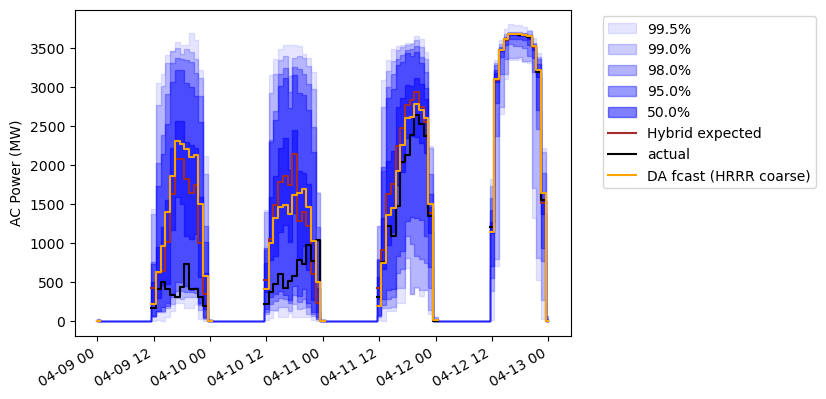

In [7]:
for i in range(num_intervals):
    alph=0.1+(i/10.)
    plt.fill_between(result_df.index,# x
                     result_df[str(percentile_list[i])+'_p_ac'].fillna(0), # lower
                     result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'].fillna(0), # upper
                     color='blue',
                     alpha=alph,
                     step='mid',
                     label=(str(pi_list[i]*100)+'%'))
    
plt.plot(result_df.index,
         result_df[str(percentile_list[int((len(percentile_list)-1)/2)])+'_p_ac'],
         label='Hybrid expected',color='brown', drawstyle='steps-mid')
plt.plot(result_df.index,result_df['p_ac_all_act'],label='actual',color='black', drawstyle='steps-mid')
plt.plot(result_df.index,result_df['p_ac_all_fcast'],label='DA fcast (HRRR coarse)',color='orange', drawstyle='steps-mid')
plt.ylabel('AC Power (MW)')
# plt.ylim([0,4500])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.gcf().autofmt_xdate()
plt.show()

For our next notebook, let's compare the 2023 results from our forecast with a reference persistence ensemble: [12_compare_with_persistence_ensemble.ipynb](12_compare_with_persistence_ensemble.ipynb).